# Import Dependencies

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D
from sklearn.metrics.pairwise import cosine_similarity

% matplotlib inline

C:\Users\hedho\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\hedho\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hedho\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])

# Load Image

In [2]:
# 讀取路徑

imgs = os.listdir(os.getcwd() + r"\比較商標\圖案")
x_train = np.empty((len(imgs)+1,224,224,3),dtype="float32")

# 讀取比較商標

for num, item in enumerate(imgs):
    img_path = os.getcwd() + r"\比較商標\圖案\\" + item
    img = image.load_img(img_path, target_size=(224, 224))
    arr = image.img_to_array(img)     
    x_train[num,:,:,:] = arr / 255

# 讀取目標商標    

img = image.load_img(os.getcwd() + r"\目標商標\\" + os.listdir(os.getcwd() + r"\目標商標")[0], target_size=(224, 224))
arr = image.img_to_array(img)
x_train[num+1,:,:,:] = arr / 255
X_image = x_train

In [3]:
# 讀取路徑

imgs = os.listdir(os.getcwd() + r"\比較商標\文字")
x_train = np.empty((len(imgs)+1,224,224,3),dtype="float32")

# 讀取比較商標

for num, item in enumerate(imgs):
    img_path = os.getcwd() + r"\比較商標\文字\\" + item
    img = image.load_img(img_path, target_size=(224, 224))
    arr = image.img_to_array(img)     
    x_train[num,:,:,:] = arr / 255

# 讀取目標商標    

img = image.load_img(os.getcwd() + r"\目標商標\\" + os.listdir(os.getcwd() + r"\目標商標")[0], target_size=(224, 224))
arr = image.img_to_array(img)
x_train[num+1,:,:,:] = arr / 255
X_text = x_train

# Extract Features with Prebulit Model

In [4]:
input_tensor = Input(shape=(224, 224, 3))

base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs=base_model.input, outputs=x)

feature_extraction_image = model.predict(X_image)
feature_extraction_text = model.predict(X_text)

# Calculate Similarity

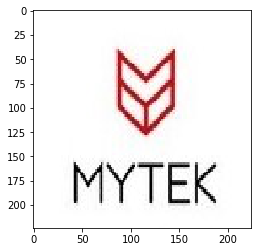

In [5]:
# Choose Target Image

input_num = -1
plt.imshow(x_train[input_num])

In [6]:
data_image = cosine_similarity(feature_extraction_image)
excel_image = pd.DataFrame(data_image[0:,0:])

data_text = cosine_similarity(feature_extraction_text)
excel_text = pd.DataFrame(data_text[0:,0:])

with pd.ExcelWriter(os.getcwd() + '\交付項目\相似分數.xlsx') as writer:
    excel_image.to_excel(writer, sheet_name='圖案')
    excel_text.to_excel(writer, sheet_name='文字')

In [7]:
# Cosine Similarity

costine_list = cosine_similarity(feature_extraction_text)[-1]

In [8]:
# Top-K 

topk = pd.DataFrame(costine_list)
topk = topk.nlargest(11,0,'last')
topk

,0
50,1.000000
38,0.637826
28,0.625849
39,0.624438
47,0.620851
30,0.608139
25,0.599461
7,0.597836
16,0.595939
18,0.595710


# Visualization 1

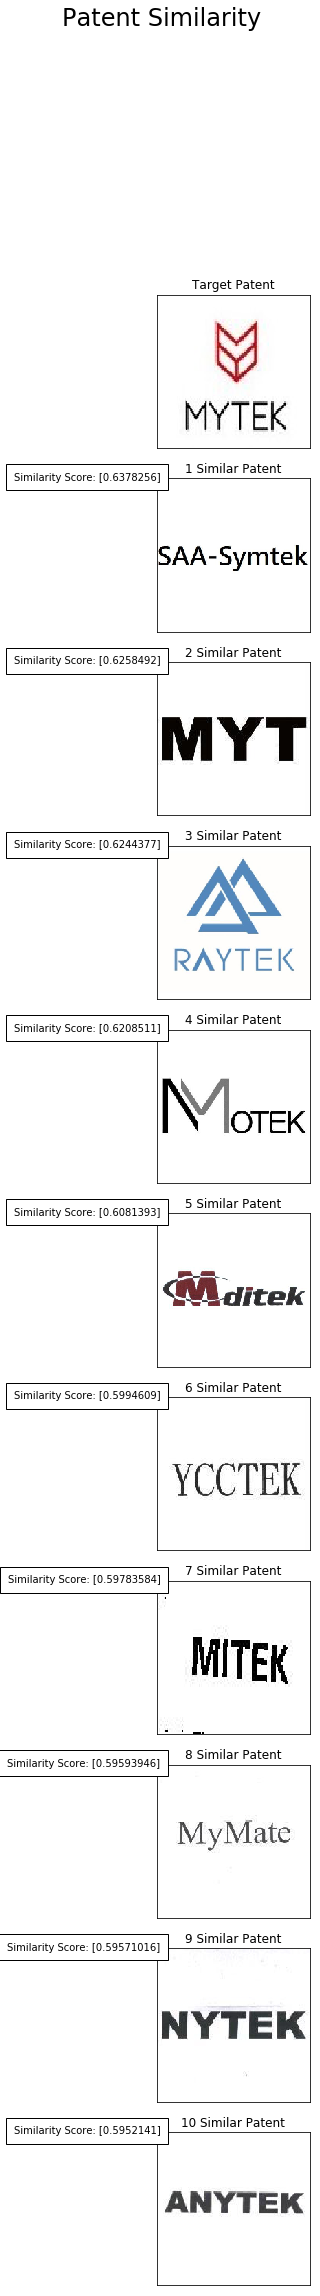

In [9]:
fig, ax = plt.subplots(figsize=(80, 40))
fig.suptitle('Patent Similarity', fontsize = 24)

# Display Original Patent
ax = plt.subplot(12, 1, 1)
plt.imshow(x_train[input_num].reshape(224, 224, 3))
ax.set_title('Target Patent')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Display Similar Patent
for i in range(2,12):
    ax = plt.subplot(12, 1, i)
    plt.imshow(x_train[topk.index[i-1]].reshape(224, 224, 3))
    ax.set_title(str(i-1) + ' Similar Patent')
    ax.text(5, 5, 'Similarity Score: ' + str(topk.iloc[i-1].values),
            verticalalignment='bottom', horizontalalignment='right',
            bbox={'facecolor': 'white', 'pad': 8})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Visualization 2

In [10]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    fig.suptitle('Patent Similarity', fontsize = 24)
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(str(n) + ' Similar Patent')
        a.text(5, 5, 'Similarity Score: ' + str(topk.iloc[n].values),
            verticalalignment='bottom', horizontalalignment='right',
            bbox={'facecolor': 'white', 'pad': 8})
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

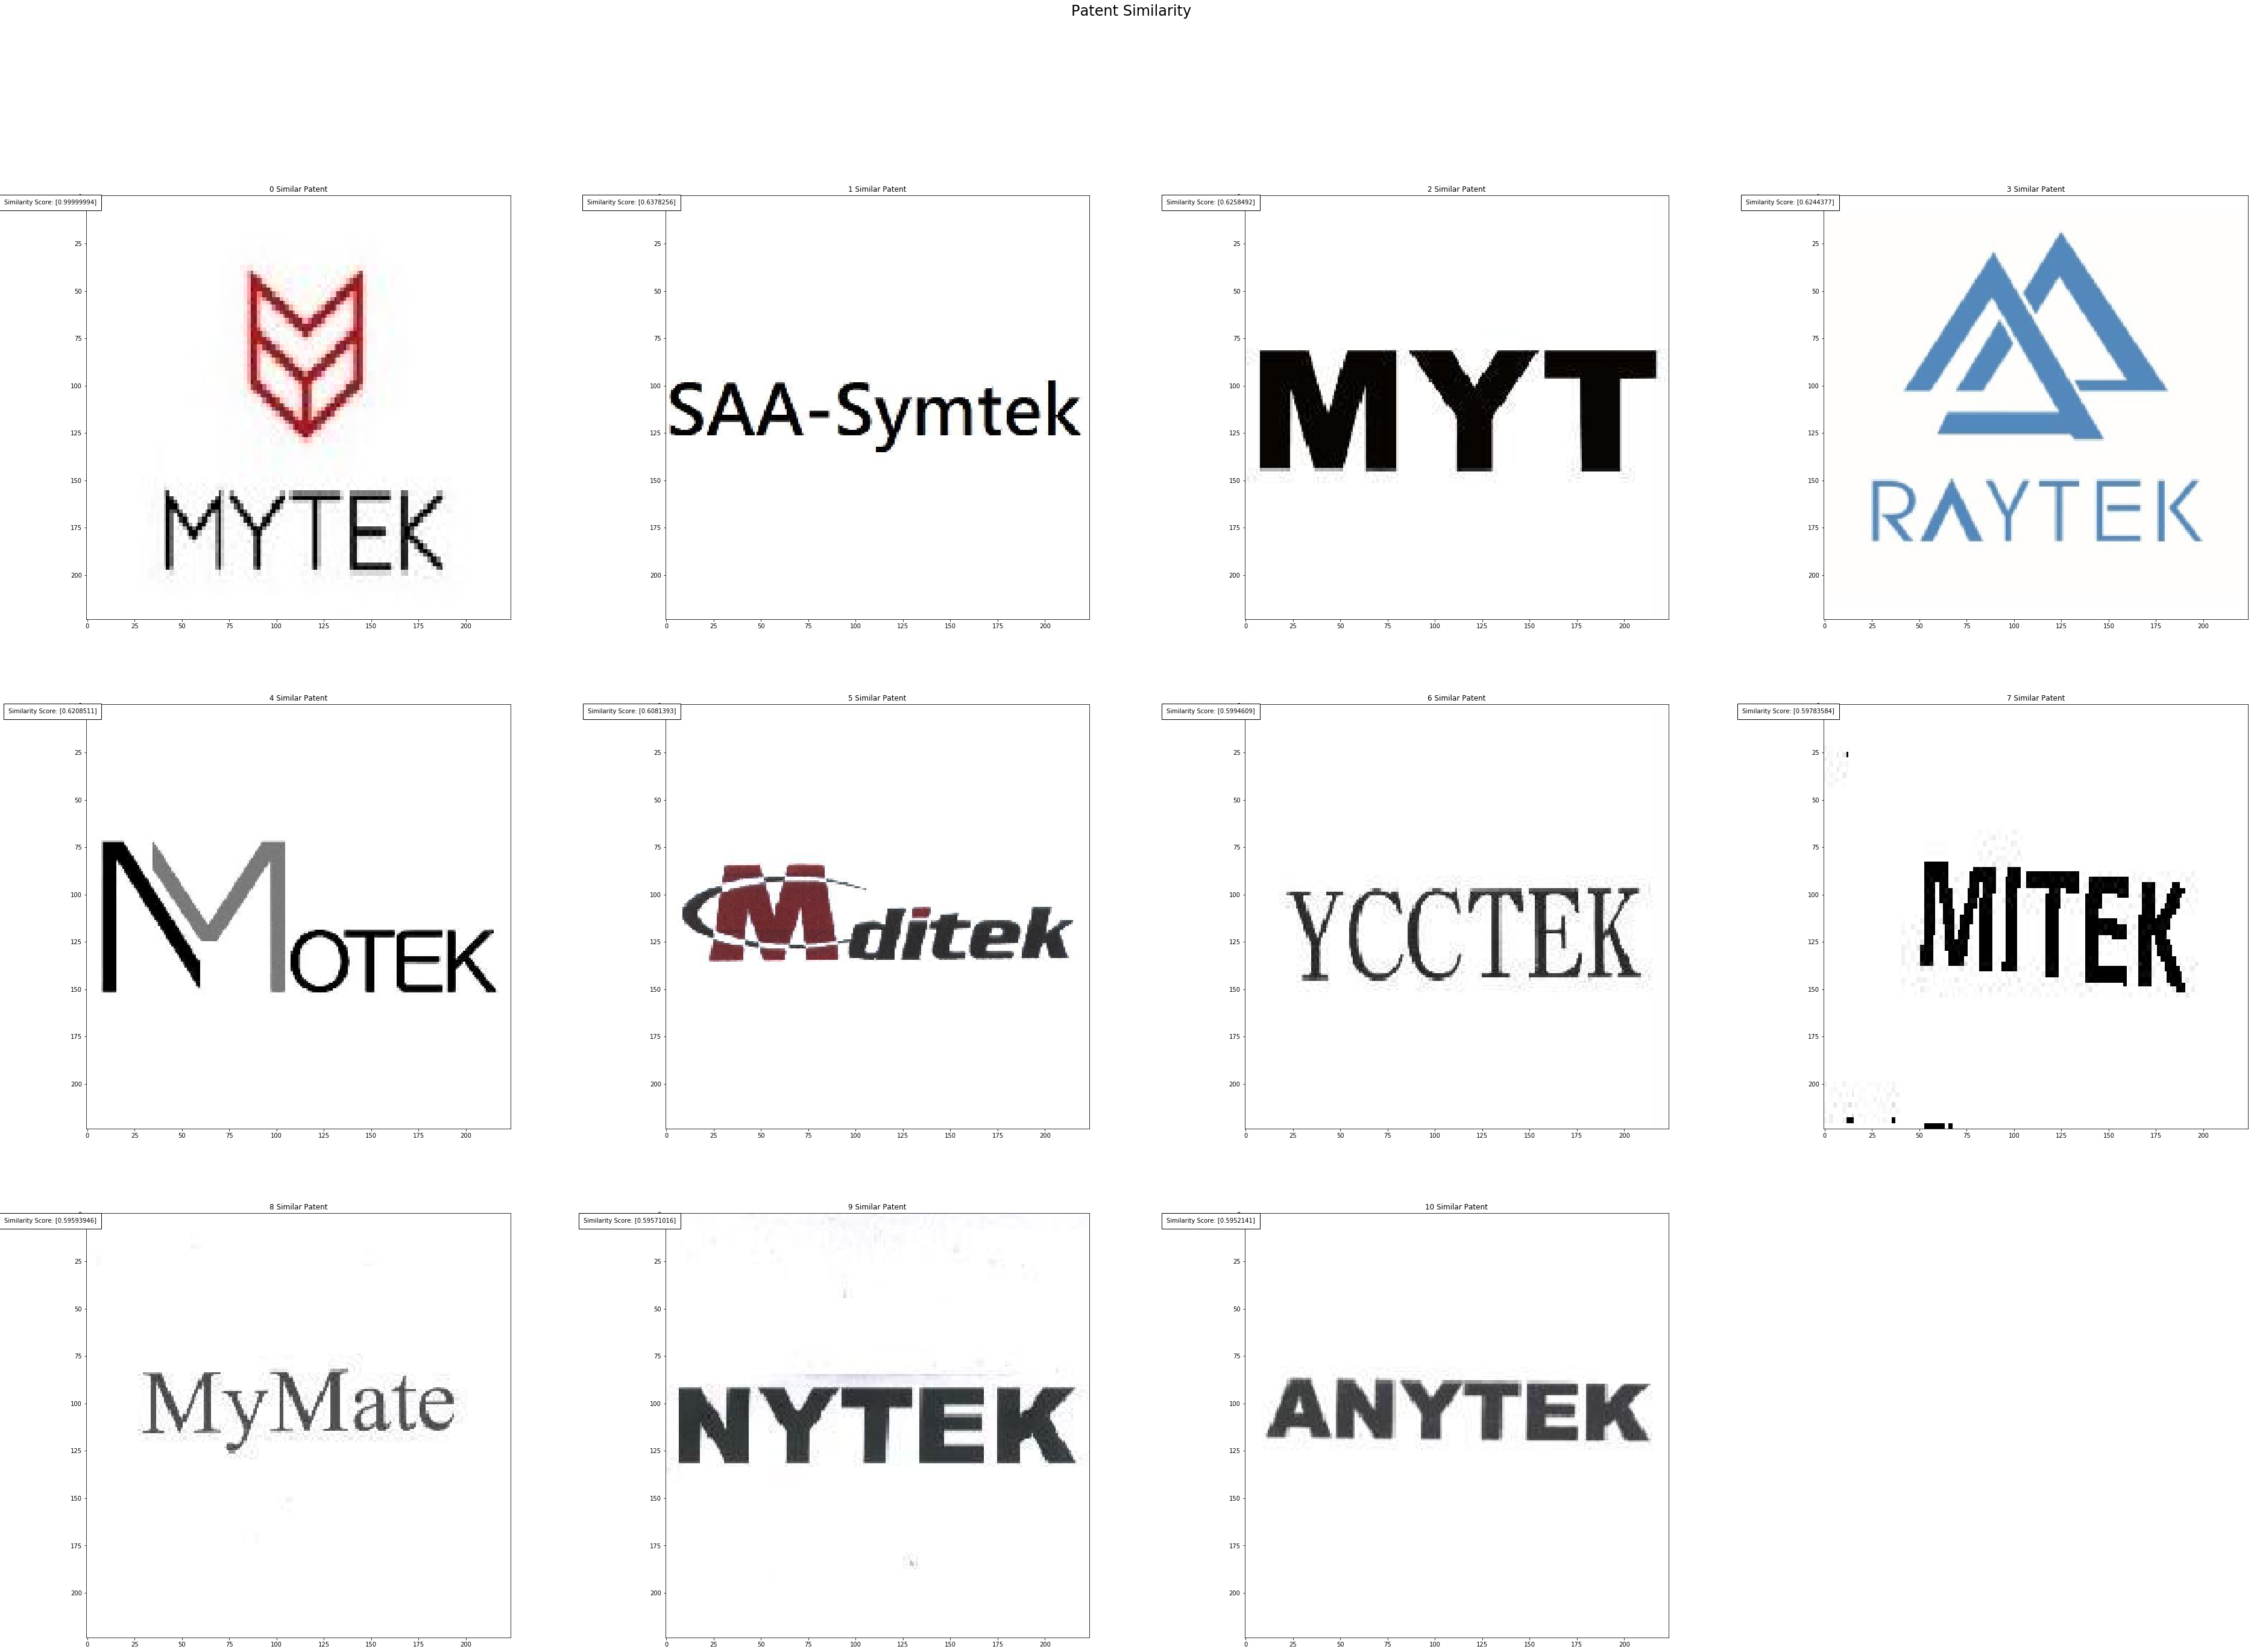

In [11]:
show_images(x_train[topk.index], cols = 3, titles = None)

# Visualization 3

In [12]:
# Dimension Reduction to 2D

from sklearn.decomposition import PCA 
from sklearn.metrics.pairwise import euclidean_distances

pca = PCA(n_components=2)
feature_2d = pca.fit_transform(feature_extraction_text)
euclidean_list_2d = euclidean_distances(feature_2d)[-1]

In [13]:
# Voronoi Diagram

from scipy.spatial import Voronoi

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all([v >= 0 for v in vertices]):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        try:
            ridges = all_ridges[p1]
        except KeyError:
            pass
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)


# make up data points
points = feature_2d

# compute Voronoi tesselation
vor = Voronoi(points)

# plot
regions, vertices = voronoi_finite_polygons_2d(vor)

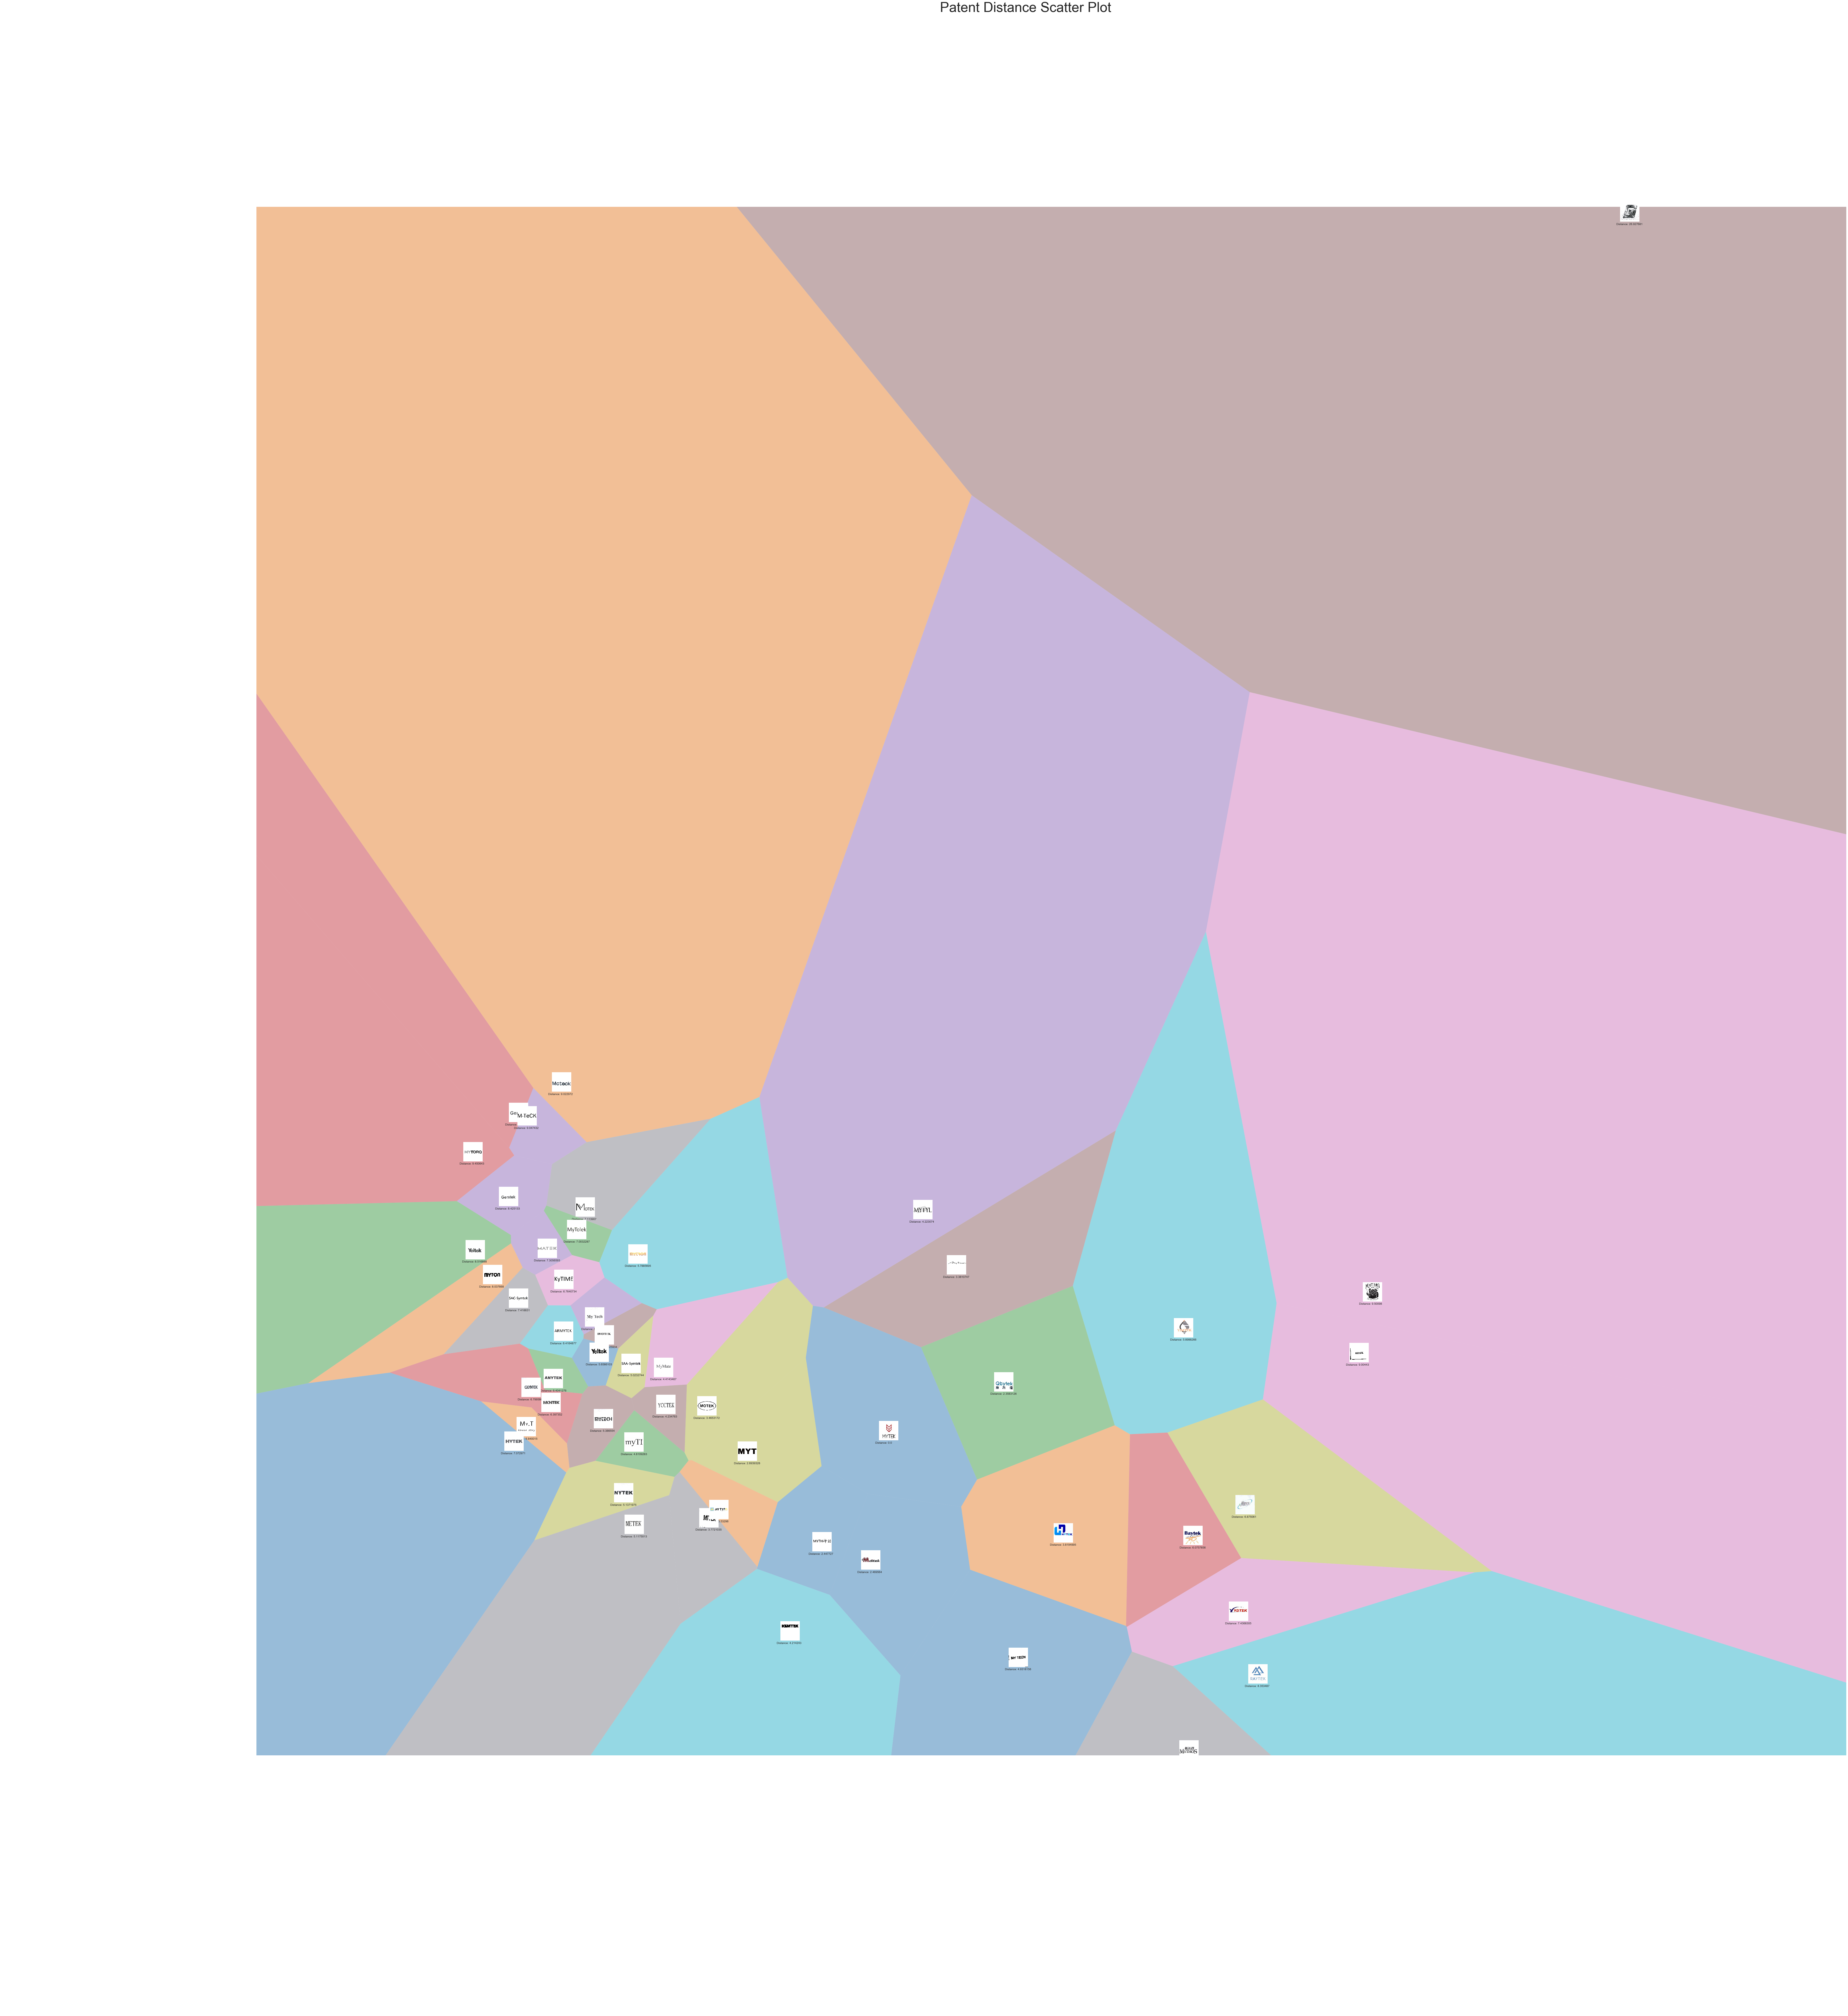

In [14]:
# Change Labels from Point to Patent Image

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

plt.style.use('seaborn-darkgrid')

def main():
    x = feature_2d[:,0]
    y = feature_2d[:,1]
    image_path = X_text
    #image_path = save_path 
    
    fig, ax = plt.subplots(figsize=(100, 100))
    imscatter(x, y, image_path, zoom=0.3, ax=ax)
    
    for i, txt in enumerate(euclidean_list_2d):
        ax.annotate('Distance: '+str(txt), (x[i]-0.25, y[i]-0.25), xycoords = 'data',
            horizontalalignment='left',
            verticalalignment='bottom')
    
    fig.suptitle('Patent Distance Scatter Plot', fontsize = 48)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    for region in regions:
        polygon = vertices[region]
        plt.fill(*zip(*polygon), alpha=0.4)
    
    plt.Circle((x[-1], y[-1]), radius=30)
    
    plt.axis('equal')
    plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
    plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)
    plt.show()

def imscatter(x, y, image_path, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    x, y = np.atleast_1d(x, y)
    artists = []
    text = []
    for num, item in enumerate(zip(x, y)):
        try:
            image = image_path[num]
            #image = plt.imread(image_path + "\\" + os.listdir(save_path)[num])
        except TypeError:
            pass
        im = OffsetImage(image, zoom=zoom)
        ab = AnnotationBbox(im, (item[0], item[1]), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    
    return artists, text

main()

# Visualization 4

In [15]:
# Kmeans Cluster
from kneed import KneeLocator

SSD = []
K=range(len(x_train))

from sklearn.cluster import KMeans 

for i in K:
    kmeans = KMeans(n_clusters=i+1, random_state=0).fit(feature_2d)
    SSD.append(kmeans.inertia_)
    
kn = KneeLocator(K, SSD, curve='convex', direction='decreasing')

kmeans = KMeans(n_clusters=kn.knee, random_state=0).fit(feature_2d)
cluster = kmeans.predict(feature_2d)
centroids = kmeans.cluster_centers_

In [16]:
from scipy.spatial import ConvexHull

# Encircle
def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)

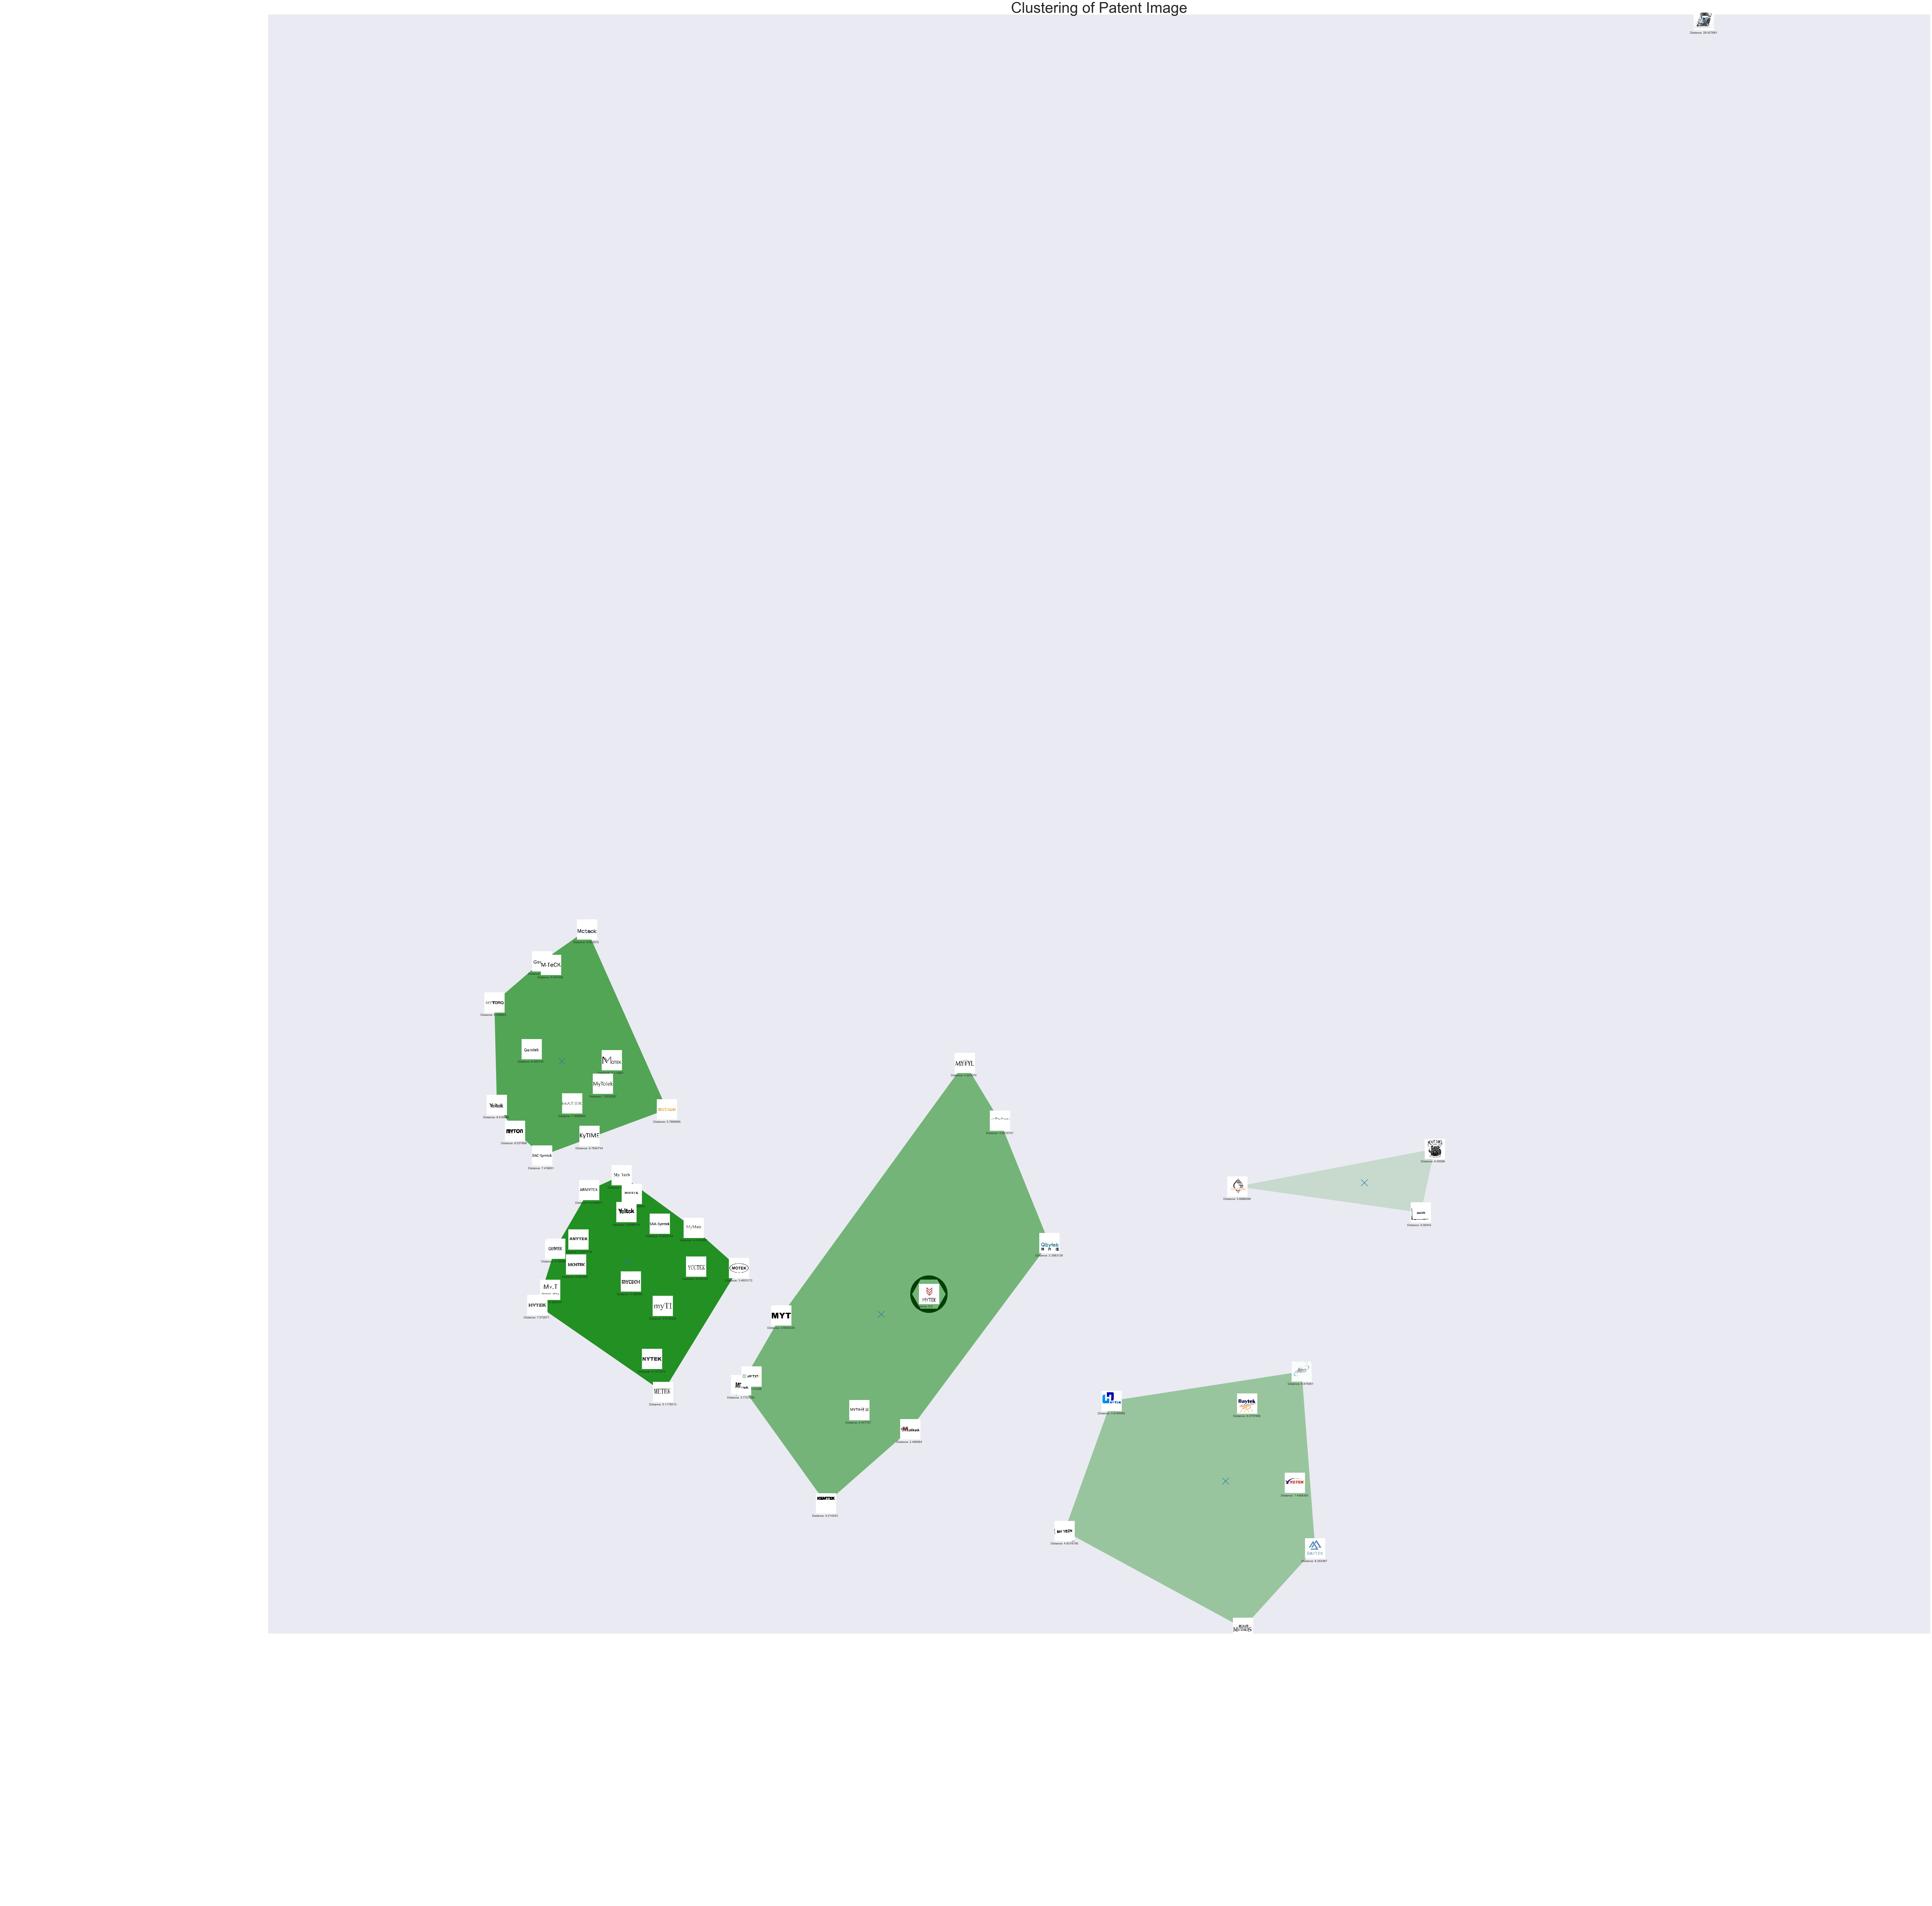

In [17]:
# Change Labels from Point to Patent Image

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

plt.style.use('seaborn-darkgrid')

def main():
    x = feature_2d[:,0]
    y = feature_2d[:,1]
    image_path = X_text
    
    fig, ax = plt.subplots(figsize=(100, 100))
    imscatter(x, y, image_path, zoom=0.3, ax=ax)
    
    for i, txt in enumerate(euclidean_list_2d):
        ax.annotate('Distance: '+str(txt), (x[i]-0.25, y[i]-0.25), xycoords = 'data',
            horizontalalignment='left',
            verticalalignment='bottom')
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    for i in range(kn.knee):
        try:
            alpha = 0.05 * len(feature_2d[np.where(cluster == i)])
            encircle(feature_2d[np.where(cluster == i)][:,0], 
                     feature_2d[np.where(cluster == i)][:,1], 
                     ec="k", fc="green", alpha=alpha, linewidth=0)
        except:
            pass
        
    plt.scatter(x[-1], y[-1], c = 'black', marker = "h", linewidths = 120)
    plt.scatter(centroids[:, 0],centroids[:, 1], marker = "x", s=500, linewidths = 500, zorder = 50)
    plt.title('Clustering of Patent Image', fontsize=50)
    plt.axis('equal')
    plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
    plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)
    plt.show()

def imscatter(x, y, image_path, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    x, y = np.atleast_1d(x, y)
    artists = []
    text = []
    for num, item in enumerate(zip(x, y)):
        try:
            image = image_path[num]
        except TypeError:
            pass
        im = OffsetImage(image, zoom=zoom)
        ab = AnnotationBbox(im, (item[0], item[1]), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    
    return artists, text

main()